In [177]:
import numpy as np
from keras.models import Sequential 
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

# 1 Prepair data for mode

We need to load the ASCII text for the book into the memory and convert all of the characters to lowercase to reduce the vocabulary that network must learn

In [178]:
filename="wonderland.txt"
raw_txt=open(filename,'r',encoding='utf-8').read()
raw_txt=raw_txt.lower()

We can't model the character directly,instead we must convert the character to integers

In [179]:
characters=list(set(raw_txt))
print(characters)

['*', 'v', '.', 'e', 'w', 'c', 'x', '-', ' ', 'r', 'b', 'u', 'f', 's', 'h', ',', 't', 'p', 'm', '!', 'g', 'l', 'd', 'a', ':', ')', '(', '_', 'k', 'z', 'n', 'q', 'y', ';', '\n', '"', '[', 'o', 'j', 'i', '?', ']', "'"]


In [180]:
characters=sorted(characters)

In [181]:
char_to_int={char:i for i,char in enumerate(characters)}

In [182]:
print(char_to_int.keys())

dict_keys(['\n', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', ':', ';', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])


You can see that there may be some characters that we could remove to futher clean up the dataset that will reduce the vocabulary and may improve the modeling process

In [183]:
n_chars=len(raw_txt)
n_vocabs=len(characters)
print("Total charactes",n_chars)
print("Total vocab:",n_vocabs)

Total charactes 144320
Total vocab: 43


- We now need to define the traning data for the network. There is lot of flexibility in how to choose to break up the text and expose it to the network during the training<br>
- In this tutorial, we will split the book text into subsequences with a fixed length of 100 characters, an arbitrary length. We could just as easly split data up by sentences and pad the shorter sequences and truncate the longer ones.
- Each traing pattern of the network is comprised of 100 time steps of one chatacter(X) followed by one character output(Y). When creating these sentences, we slide the windown along the whole book one character at a time,allowing each character a chance to be learned from 100 characters that preceded it(except the first 100 character of course)

In [184]:
seq_length=100
dataX=[]
dataY=[]
for i in range(0,n_chars-seq_length,1):
  seq_in=raw_txt[i:i+seq_length]
  seq_out=raw_txt[i+seq_length]
  dataX.append([char_to_int[s] for s in seq_in])
  dataY.append(char_to_int[seq_out])
n_inputs=len(dataX)
print("Number input for Model:",n_inputs)

Number input for Model: 144220


- Now that we have prepaired our training data we need to transform it so that it suitable for use with keras<br>
- First we need transofrm the list of input sequendes into the form(samples,time_steps,features) expected by an LSTM network


In [185]:
X=np.reshape(dataX,(n_inputs,seq_length,1))
X=X/n_vocabs
Y=to_categorical(dataY)

In [186]:
print(Y.shape)

(144220, 43)


# 2 Build mode 

In [204]:
epochs=100

In [207]:
model=Sequential()
model.add(LSTM(256,input_shape=(X.shape[1],X.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(Y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [208]:
filepath="weight-improvement-100-{loss:.4f}.hdf5"
checkpoint=ModelCheckpoint(filepath,monitor='loss',verbose=1,save_best_only=True,mode='min')
callbacks_list=[checkpoint]

In [209]:
!rm *.hdf5

rm: cannot remove '*.hdf5': No such file or directory


In [210]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 100, 256)          264192    
_________________________________________________________________
dropout_24 (Dropout)         (None, 100, 256)          0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 43)                11051     
Total params: 800,555
Trainable params: 800,555
Non-trainable params: 0
_________________________________________________________________


In [211]:
history=model.fit(X,Y,epochs=epochs,batch_size=256,callbacks=callbacks_list)

Epoch 1/100
563/564 [============================>.] - ETA: 0s - loss: 2.9651 - accuracy: 0.1874
Epoch 00001: loss improved from inf to 2.96485, saving model to weight-improvement-100-2.9648.hdf5
564/564 [==============================] - 22s 39ms/step - loss: 2.9648 - accuracy: 0.1874
Epoch 2/100
563/564 [============================>.] - ETA: 0s - loss: 2.6638 - accuracy: 0.2555
Epoch 00002: loss improved from 2.96485 to 2.66372, saving model to weight-improvement-100-2.6637.hdf5
564/564 [==============================] - 22s 39ms/step - loss: 2.6637 - accuracy: 0.2555
Epoch 3/100
563/564 [============================>.] - ETA: 0s - loss: 2.4899 - accuracy: 0.2920
Epoch 00003: loss improved from 2.66372 to 2.48970, saving model to weight-improvement-100-2.4897.hdf5
564/564 [==============================] - 22s 40ms/step - loss: 2.4897 - accuracy: 0.2920
Epoch 4/100
563/564 [============================>.] - ETA: 0s - loss: 2.3414 - accuracy: 0.3292
Epoch 00004: loss improved from 2.

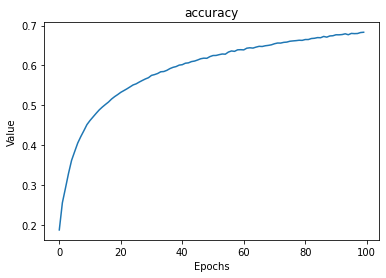

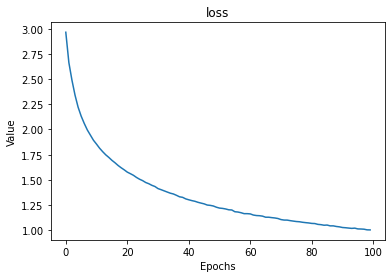

In [212]:
from matplotlib import pyplot as plt
x_value=np.arange(epochs)
labels=['accuracy','loss']
for i in range(2):
  plt.plot(x_value,history.history[labels[i]])
  plt.xlabel('Epochs')
  plt.ylabel('Value')
  plt.title(labels[i])
  plt.show()

In [213]:
file_weight='weight-improvement-100-1.0038.hdf5'
model.load_weights(file_weight)
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [214]:
start=np.random.randint(0,len(dataX)-1)
print(start)

115095


In [215]:
int_to_char={i:char for i,char in enumerate(characters)}
pattern=dataX[start]

In [220]:
temp=''.join(int_to_char[value] for value in pattern)
print(temp)

he shone cars and she way in that sable. 
'i don't know what you may not have aeein with mise!' said


In [221]:
import sys
sys.stdout.write(temp)
for i in range(1000):
  x=np.reshape(pattern,(1,len(pattern),1))
  x=x/float(n_vocabs)
  prediction=model.predict(x,verbose=0)
  index=np.argmax(prediction)
  character=int_to_char[index]
  sys.stdout.write(character)
  pattern.append(index)
  pattern=pattern[1:len(pattern)]

he shone cars and she way in that sable. 
'i don't know what you may not have aeein with mise!' said the daterpillar.

'i don't kike the thable were that i've been po a dande is ' said the mock turtle. ''she dar't got be to pakence the sea-' she said to herself, 'i wesh the boors with the little door, but she could not seemed to be no coubt to hear it was on touithbtier, and the thal crundir she was to tee it all too craape,

'well, i sean't help to sime,  said the caterpillar.

'i don't know what you may not it,' said the mock turtle. ''she dar't gall to the bastt to make mut the remerkented thene was a doow,' said the mock turtle, 'ne course you know what to be a little bit!'

'i don't kike the than thlesce,' said the caterpillar.

'i don't kike that dormouse ' said alice, 'i'm afraid i mnow you wouldn't say it to tell me bothoe! i wonder what to be a little bit! i shall be saleari it wiile you meven teem the lors ascym' i think i can tery minely seally marged.'

'i haven't the shing